# 2.8 Multi-Agent 시스템과 RouteLLM

- 앞에서 개발한 `소득세 에이전트`와 `종합부동산세 에이전트`를 활용해서 다중 에이전트 시스템을 구현합니다

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model="gpt-4o"   
)

small_llm = ChatOpenAI(
    model='gpt-4o-mini'
)

State 작성: 기존과 동일

In [3]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str
    context: list
    answer: str
    
graph_builder = StateGraph(AgentState)

라우터 정의: Adaptive rag에서 정의한 것 수정

In [4]:
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from typing import Literal

class Route(BaseModel):
    target: Literal['income_tax', 'llm', 'real_estate_tax'] = Field(
        description="The target for the query to answer"
    )

router_system_prompt = """
You are an expert at routing a user's question to 'income_tax', 'llm', or 'real_estate_tax'.
'income_tax' contains information about income tax up to December 2024.
'real_estate_tax' contains information about real estate tax up to December 2024.
if you think the question is not related to either 'income_tax' or 'real_estate_tax';
you can route it to 'llm'."""


router_prompt = ChatPromptTemplate.from_messages([
    ('system', router_system_prompt),
    ('user', '{query}')
])

structured_router_llm = small_llm.with_structured_output(Route)

def router(state: AgentState) -> Literal['income_tax', 'real_estate_tax', 'llm']:
    """
    주어진 state에서 쿼리를 기반으로 적절한 경로를 결정합니다.

    Args:
        state (AgentState): 현재 에이전트의 state를 나타내는 객체입니다.

    Returns:
        Literal['income_tax', 'real_estate_tax', 'llm']: 쿼리에 따라 선택된 경로를 반환합니다.
    """
    query = state['query']
    router_chain = router_prompt | structured_router_llm 
    route = router_chain.invoke({'query': query})

    return route.target

- 라우터는 컨디셔널 엣지이므로 노드에 추가되지는 않는다.

일반 답변 LLM

In [5]:
from langchain_core.output_parsers import StrOutputParser

def call_llm(state: AgentState) -> AgentState:
    """
    주어진 state에서 쿼리를 LLM에 전달하여 응답을 얻습니다.

    Args:
        state (AgentState): 현재 에이전트의 state를 나타내는 객체입니다.

    Returns:
        AgentState: 'answer' 키를 포함하는 새로운 state를 반환합니다.
    """
    query = state['query']
    llm_chain = small_llm | StrOutputParser()
    llm_answer = llm_chain.invoke(query)
    return {'answer': llm_answer}

노드 추가  
- 앞에서 작성한 그래프 들도 노드로 추가

In [6]:
from income_tax_graph import graph as income_tax_agent
from real_estate_tax_graph import graph as real_estate_tax_agent

graph_builder.add_node('income_tax', income_tax_agent)
graph_builder.add_node('real_estate_tax', real_estate_tax_agent)
graph_builder.add_node('llm', call_llm)

엣지 연결

In [7]:
from langgraph.graph import START, END

graph_builder.add_conditional_edges(
    START,
    router,
    {
        'income_tax': 'income_tax',
        'real_estate_tax': 'real_estate_tax',
        'llm': 'llm'
    }
)
graph_builder.add_edge('income_tax', END)
graph_builder.add_edge('real_estate_tax', END)
graph_builder.add_edge('llm', END)

In [8]:
graph = graph_builder.compile()

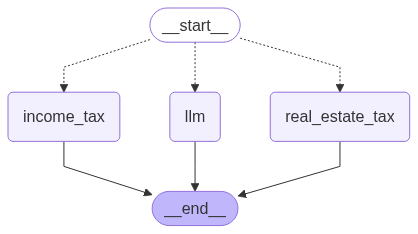

In [9]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
initial_state = {'query': '소득세란 무엇인가요?'}
graph.invoke(initial_state)

{'query': '소득세란 무엇인가요?',
 'context': [Document(metadata={'source': './documents/income_tax.txt'}, page_content='소득세법\n[시행 2025. 1. 1. | 법률 제20615호, 2024. 12. 31., 일부개정]\n기획재정부 (세정과) 044-215-4312\n기획재정부 (소득세제과) 044-215-4216\n기획재정부 (금융세제과) 044-215-4233\n기획재정부 (소득세제과(사업소득, 기타소득)) 044-215-4217\n제1장 총칙\n개정 2009. 12. 31.\n제2조(정의)\n이 법은 개인에 대한 소득의 성격과 납세자의 부당능력 등에 따라 적정하게 과세함으로써 조세부담의 형평을 도모하고 재정수입의 원활한 조달에 이바지함을 목적으로 한다.\n[본 조신설 2009. 12. 31.]\n[중전 제1조는 제2조로 이동 2009. 12. 31.]\n제2조의2(해외민간)\n이 법에서 사용하는 용어의 뜻은 다음과 같다. \n1. "거주자"란 국내에 주거를 둔지 183일 이상인 거주(居住)하는 개인을 말한다.\n2. "비거주자"란 거주자가 아닌 개인을 말한다.\n3. "내국법인"이란 법인세법 제2조제1호에 따른 내국법인을 말한다.\n4. "외국법인"이란 법인세법 제2조제3호에 따른 외국법인을 말한다.\n5. "사업자"란 사업소의 있는 거주자를 포함한다.\n   ○ 제1항에 따른 수스·거주자·비거주자의 구분은 대통령령으로 정한다.\n[본 조신설 2009. 12. 31.]\n제2조(납세의무)\n다음 각 호의 어느 하나에 해당하는 개인은 이 법에 따라 각자의 소득에 대한 소득세를 납부할 의무를 진다.\n1. 거주자\n2. 비거주자로서 국내원천소득(國內源泉所屬)이 있는 개인\n3. 다음 각 호의 어느 하나에 해당하는 자는 이 법에 따라 원천징수한 소득세를 납부할 의무를 진다.\n1. 거주자\n2. 비거주자\n3. 내국법인\n4. 외국법인의 국내지점 또는 국내영업소(출장소, 그 밖에

In [11]:
initial_state = {
    'query': '집 15억은 세금을 얼마나 내나요?'
}

graph.invoke(initial_state)

{'query': '집 15억은 세금을 얼마나 내나요?',
 'answer': '종합부동산세를 정확히 계산하기 위해서는 공제금액과 세율 정보가 필요합니다. 일반적으로 공제금액과 세율은 국가의 세법과 정책에 따라 다르고, 매년 변경될 수 있습니다. 그러나 대략적인 과세표준 계산과 세율 적용 방법을 설명할 수 있습니다.\n\n먼저, 과세표준을 계산해야 합니다. 주어진 정보에 따르면, 1주택자의 경우 공정시장가액비율은 45%입니다. 따라서, 과세표준은 다음과 같이 계산됩니다:\n\n과세표준 = (공시가격 × 공정시장가액비율) - 공제금액\n\n주어진 공시가격이 15억 원이고, 공정시장가액비율이 45%이므로:\n\n과세표준 = (15억 원 × 45%) - 공제금액\n과세표준 = 6억 7천 5백만 원 - 공제금액\n\n여기서 공제금액이 주어지지 않았기 때문에, 정확한 과세표준을 계산할 수 없습니다. \n\n다음으로, 과세표준에 적용되는 세율을 알아야 합니다. 일반적으로 1주택자와 다주택자의 세율은 다르게 적용되며, 과세표준 범위에 따라 세율이 다르게 적용됩니다. 1주택자의 경우, 보통 낮은 세율이 적용됩니다.\n\n예를 들어, 과세표준이 6억 7천 5백만 원이고, 해당 금액 구간에 적용되는 세율이 1%라고 가정하면:\n\n종합부동산세 = 과세표준 × 세율\n종합부동산세 = 6억 7천 5백만 원 × 1%\n\n그러나, 정확한 세율을 적용하기 위해서는 최신의 세법 정보와 공제금액 정보를 참조해야 합니다. 세율과 공제금액 정보는 정부의 세금 관련 부처에서 제공하는 최신 자료를 통해 확인하실 수 있습니다.'}

In [12]:
initial_state = {'query': '떡볶이는 어디가 맛있나요?'}
graph.invoke(initial_state)

{'query': '떡볶이는 어디가 맛있나요?',
 'answer': '떡볶이는 한국의 대표적인 길거리 음식으로, 지역마다 맛이 다르게 느껴질 수 있습니다. 서울의 경우, 명동, 홍대, 강남 등에서 유명한 떡볶이 가게들이 많이 있습니다. 특히 명동의 "신당동 떡볶이"나 홍대의 "떡볶이 집"이 인기가 많습니다. \n\n부산에서는 "부산 떡볶이"로 알려진 매운 떡볶이가 유명하며, 자갈치 시장 근처에서 맛볼 수 있습니다. \n\n각 지역마다 특색 있는 맛과 재료를 사용하니, 다양한 곳에서 떡볶이를 시도해보는 것도 좋습니다!'}